<a href="https://colab.research.google.com/github/ezzatmostafa96/Independent-Projects/blob/master/Training_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
import numpy as np
import pandas as pd

import os
import ntpath
import pickle
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import cv2 as cv
from google.colab.patches import cv2_imshow

import keras #Nueral Netwrok Library
from keras import layers
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, LSTM, ZeroPadding3D, Input, TimeDistributed, Conv2D, Activation
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16



classes = {'Anomaly':0, 'Normal':1}
no_classes = len(classes)

! mkdir Dataset
! mkdir Dataset/Videos
import os
print("Class Arrest: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Arrest_crop"))))
print("Class Assault: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Assault_crop"))))
print("Class Burglary: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Burglary_crop"))))
print("Class Robbery: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Robbery_crop"))))
print("Class Stealing: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Stealing_crop"))))
print("Class Vandalism: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Vandalism_crop"))))
print("Class Normal: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Normal_1_crop"))))
print("Class Normal: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Normal_2_crop"))))
classes = ["Anomaly", "Normal"]
f = open("Dataset/classes.txt", 'w');
for i in range(len(classes)):
    f.write(classes[i] + "\n");
f.close();



import os
from tqdm import tqdm
combined = [];




Class Arrest: 13
Class Assault: 18
Class Burglary: 17
Class Robbery: 18
Class Stealing: 15
Class Vandalism: 18
Class Normal: 129
Class Normal: 71


In [2]:
!cp -a /content/drive/MyDrive/All_Croped  /content 

In [3]:
base_directory = "/content/All_Croped/"

In [4]:
%cd /content/All_Croped
!mkdir Anomaly 

/content/All_Croped


In [5]:
!mkdir Normal  

In [6]:
!cp -a /content/All_Croped/Arrest_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Assault_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Burglary_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Robbery_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Stealing_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Vandalism_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Normal_1_crop/. /content/All_Croped/Normal/
!cp -a /content/All_Croped/Normal_2_crop/. /content/All_Croped/Normal/


In [7]:
!rm -rf /content/All_Croped/Arrest_crop
!rm -rf /content/All_Croped/Assault_crop
!rm -rf /content/All_Croped/Burglary_crop
!rm -rf /content/All_Croped/Robbery_crop
!rm -rf /content/All_Croped/Stealing_crop
!rm -rf /content/All_Croped/Vandalism_crop
!rm -rf /content/All_Croped/Normal_1_crop
!rm -rf /content/All_Croped/Normal_2_crop


In [8]:
pwd

'/content/All_Croped'

In [9]:
%cd /content

/content


In [10]:
folder_name = "All_Croped/"
class_name = "Normal";
folder_name += class_name + "/";

vid_list = os.listdir(folder_name);
for i in tqdm(range(len(vid_list))):
    os.system("cp " + folder_name + vid_list[i] + " Dataset/Videos/")
    wr = vid_list[i] + " " + str(classes.index(class_name))
    combined.append(wr)

folder_name = "All_Croped/"
class_name = "Anomaly";
folder_name += class_name + "/";

vid_list = os.listdir(folder_name);
for i in tqdm(range(len(vid_list))):
    os.system("cp " + folder_name + vid_list[i] + " Dataset/Videos/")
    wr = vid_list[i] + " " + str(classes.index(class_name))
    combined.append(wr)

100%|██████████| 99/99 [00:00<00:00, 101.96it/s]


In [12]:
pwd

'/content'

In [13]:
!mkdir Videos

In [ ]:
!pip install split-folders tqdm
import splitfolders  # or import split_folders
splitfolders.ratio("/content/All_Croped", output="/content/Videos", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

In [16]:
!mv /content/Dataset /content/Dataset2

In [17]:
!mv /content/Videos /content/Dataset



Copying files: 0 files [00:00, ? files/s]

Copying files: 84 files [00:00, 825.97 files/s]

Copying files: 142 files [00:00, 730.48 files/s]

Copying files: 179 files [00:00, 561.05 files/s]

Copying files: 215 files [00:00, 466.08 files/s]

Copying files: 299 files [00:00, 514.02 files/s]


In [18]:
classes = {'Anomaly':0, 'Normal':1}
no_classes = len(classes)

base_directory = "/content/Dataset/"

In [20]:
train_path = base_directory + "Training_set"
test_path  = base_directory + "Testing_set"

In [47]:
def read_train_data_paths():
    data_paths = []
    truth = []

    for class_name in classes:
        for file in tqdm(os.listdir(train_path + "/" + class_name)):
            vid_path = os.path.join(train_path + "/" + class_name, file)
            data_paths.append(vid_path)
            truth.append(classes[class_name])
    
    return data_paths, truth



def read_test_data_paths():
    data_paths = []

    for file in tqdm(os.listdir(test_path)):
        vid_path = os.path.join(test_path, file)
        data_paths.append(vid_path)
    
    return data_paths


def get_test_data_names():
    data_names = []
    for file in tqdm(os.listdir(test_path)):
        data_names.append(file)
    
    return data_names

def know_about_train_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))

    print("\nWe have", len(vids_shape), " videos.")


    data_counter = {'Anomaly':0, 'Normal':0}
    for class_name in classes:
            data_counter[class_name] = len(os.listdir(train_path + "/" + class_name))

    print("Videos are divided into ", data_counter)
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))




def know_about_test_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))
    
    print("\nWe have", len(vids_shape), " videos.")
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))




D = 16   #New Depth size => Number of frames.
W = 112  #New Frame Width.
H = 112  #New Frame Height.
C = 3    #Number of channels.
sample_shape = (D, W, H, C) #Single Video shape.




def preprocess(data_paths, data_truth):
    all_videos = []

    for i in tqdm(range(len(data_paths))):
        cap = cv.VideoCapture(data_paths[i])

        single_video_frames = []
        while (True):
            read_success, current_frame = cap.read()
            
            if not read_success:
                break

            current_frame = cv.resize(current_frame, (W, H))
            single_video_frames.append(current_frame)

        cap.release()

        single_video_frames = np.array(single_video_frames)
        single_video_frames.resize((D,W,H,C))

        all_videos.append(single_video_frames)
    
    all_videos = np.array(all_videos)
    data_truth = np.array(data_truth)

    return all_videos, data_truth
    

In [44]:
!wget https://privdatastorage.blob.core.windows.net/github/video-action-recognition/weights_C3D_sports1M_tf.h5

--2020-12-03 15:54:53--  https://privdatastorage.blob.core.windows.net/github/video-action-recognition/weights_C3D_sports1M_tf.h5
Resolving privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)... 52.239.140.10
Connecting to privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)|52.239.140.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320010556 (305M) [application/octet-stream]
Saving to: ‘weights_C3D_sports1M_tf.h5’

weights_C3D_sports1 100%[===================>] 305.19M  16.1MB/s    in 22s     

2020-12-03 15:55:15 (14.1 MB/s) - ‘weights_C3D_sports1M_tf.h5’ saved [320010556/320010556]



In [24]:
%cd /content
!mkdir Weights

/content


In [26]:
!mv  /content/weights_C3D_sports1M_tf.h5 /content/Weights

In [27]:
# Model configuration
model = None

CNN_type  = 0
LSTM_type = 1

weights_path = base_directory + "Weights/weights_C3D_sports1M_tf.h5"

In [45]:
def create_model(model_type):
    global model
    if model_type == CNN_type:
        create_3D_CNN_model()
        compile_model()
        model.save(base_directory + "Models/CNN_3D_Model")
    else:
        create_LSTM_model()
        compile_model()
        model.save(base_directory + "Models/LSTM_Model")



def compile_model():
    global model
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
    

def load_model(model_type):
    global model
    if model_type == CNN_type:
        model = keras.models.load_model(base_directory + "Models/CNN_3D_Model")
    else:
        model = keras.models.load_model(base_directory + "Models/LSTM_Model")




# Create the model
def create_3D_CNN_model():
    global model
    model = Sequential(name="3D-CNN Model")

    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3), activation="relu",name="conv1", 
                        input_shape=(D, W, H, C),
                        strides=(1, 1, 1), padding="same"))  
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid"))

    # 2nd layer group  
    model.add(Conv3D(128, (3, 3, 3), activation="relu",name="conv2", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid"))

    # 3rd layer group   
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3a", 
                        strides=(1, 1, 1), padding="same"))
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3b", 
                        strides=(1, 1, 1), padding="same"))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool3", padding="valid"))

    # 4th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4b", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool4", padding="valid"))

    # 5th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5b",
                        strides=(1, 1, 1), padding="same"))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool5", padding="valid"))
    model.add(Flatten())
                        
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))


    if weights_path:
        model.load_weights(weights_path)

    #Make Changes for our model.
    model.layers.pop() #Remove last layer. as the number of classes used is not as same our data.
    pre_last_layer_output = model.layers[-1].output
    last_layer_output = Dense(no_classes, activation='softmax', name='fc9')(pre_last_layer_output)

    model = Model(model.input, last_layer_output)

    for layer in model.layers[:-5]:
        layer.trainable=False



def build_vgg(shape):
    vgg = VGG16(weights="imagenet", input_shape=shape, include_top=False)
    
    return vgg

def create_LSTM_model():
    global model

    vggModel = build_vgg((W,H,C))
    for layer in vggModel.layers[:-1]:
        layer.trainable=False

    model = Sequential()
    input_layer = Input(shape=(D, W, H, C))
    model = TimeDistributed(vggModel)(input_layer) 
    model = TimeDistributed(Flatten())(model)
    
    model = LSTM(128, return_sequences=False)(model)
    model = Dropout(.5)(model)
    
    output_layer = Dense(no_classes, activation='softmax')(model)

    model = Model(input_layer, output_layer)



def train(X_train, y_train, val_split):
    global model
    global validation_split
    validation_split = val_split
    
    # Convert target vectors to categorical targets
    y_train = to_categorical(y_train).astype(np.integer)
    
    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_split=val_split)
    


def test(X_test, y_test):
    # Convert target vectors to categorical targets
    y_test = to_categorical(y_test).astype(np.integer)
    
    # Generate generalization metrics
    model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)

    return model_loss, model_accuracy, y_pred


def predict(X_test):
        y_pred = model.predict(X_test)
        return y_pred


def save_structure(structure, name):
    with open(base_directory + 'Structures/' + name + '.pickle', 'wb') as handle:
        pickle.dump(structure, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_structure(name):
    if os.path.isfile(base_directory + 'Structures/' + name + '.pickle'):
        with open(base_directory + 'Structures/' + name + '.pickle', 'rb') as handle:
            structure = pickle.load(handle)
        return structure
    else:
        return []


def get_class(value):
    value = get_value(value)
    for class_name in classes:
        if classes[class_name] == value:
            return class_name


def shuffle(X_data, y_data):
    X_data_series = pd.Series(X_data)
    y_data_series = pd.Series(y_data)

    dataFrame = pd.DataFrame()
    dataFrame = pd.concat([X_data_series, y_data_series], axis=1)

    dataArray = np.array(dataFrame)
    np.random.shuffle(dataArray)
    
    return dataArray[:,0], dataArray[:,1]


#A value is either equal to a 'label index' of a 'categorical list' that indicates which label.
#ex:
#if value = 2 or value = [0, 0, 1, 0, 0]:
#return 2
def get_value(value):
    if type(value) == type([]) or type(value) == type(np.array([])):
        return np.argmax(value)
    return value


def create_predictions_csv_file(model_name, predictions):
    pred = []

    data_names = get_test_data_names()
    for i in range(len(predictions)):
        pred.append([data_names[i], get_value(predictions[i])])

    np_predictions = np.array(pred)
    np.savetxt(fname=model_name + "_predictions.csv", X=np_predictions, delimiter=",", fmt='%s')

def have_a_look(X_data, y_data):
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(X_data),36))): #Pick random 36 videos
        plt.subplot(6,6,n+1)
        plt.axis('off')

        label = y_data[i] #ex-> label = [0.2, 0.3, 0.2, 0.8, 0.6]
        plt.title(get_class(get_value(label))) #The highest value is 0.8 which is at class no. 4

        first_frame = X_data[i][0] #Pick first frame of this video.
        if C == 1:
            first_frame = first_frame.reshape((W,H))
        plt.imshow(first_frame)


def plot_model_metrics(history):
    plt.figure(figsize=(8, 4))
    plt.title('Model Performance for Video Action Detection', size=18, c="C7")
    plt.ylabel('Loss value', size=15, color='C7')
    plt.xlabel('Epoch No.', size=15, color='C7')
    #plt.plot(history.history['loss'],  'o-', label='Training Data Loss', linewidth=2, c='C3') #C3 = red color.
    plt.plot(history.history['accuracy'],  'o-', label='Training Data Accuracy', linewidth=2, c='C2') #C2 = green color.

    if len(history.history) > 2:
        plt.plot(history.history['val_accuracy'],  'o-', label='Validation Data Accuracy', linewidth=2, c='b') #b = blue color.

    plt.legend()    
    plt.show()   

In [31]:
batch_size = 50
no_epochs = 50
learning_rate = 0.0001
validation_split = 0.2
verbosity = 1

In [32]:
load_tracker = {"CNN_3D_Model":"n",
                "LSTM_Model":"n",
                "train_data":"n",
                "test_data":"n",
                }

for file_name in load_tracker:
    user_input = input("Load " + file_name + " y/n? ")
    load_tracker[file_name] = user_input

print('\n', load_tracker)

Load CNN_3D_Model y/n? n
Load LSTM_Model y/n? n
Load train_data y/n? n
Load test_data y/n? n

 {'CNN_3D_Model': 'n', 'LSTM_Model': 'n', 'train_data': 'n', 'test_data': 'n'}


In [33]:
model_id = int(input("Which model to run? '0' for 3D_CNN and '1' for LSTM? "))

model_name = 'CNN_3D_Model'

if model_id == 1:
    model_name = "LSTM_Model"

print('\nChosen Model: ' + model_name)

Which model to run? '0' for 3D_CNN and '1' for LSTM? 0

Chosen Model: CNN_3D_Model


In [34]:
if load_tracker["train_data"] == "n":
    print("Reading Training Data..")
    trainingData_paths, y_train = read_train_data_paths()
    trainingData_paths, y_train = shuffle(trainingData_paths, y_train)



100%|██████████| 79/79 [00:00<00:00, 157261.52it/s]


100%|██████████| 160/160 [00:00<00:00, 176277.55it/s]

Reading Training Data..


In [35]:
if load_tracker["train_data"] == "n":
    know_about_train_data(trainingData_paths)



  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 1/239 [00:00<00:49,  4.80it/s]

100%|██████████| 239/239 [00:00<00:00, 622.66it/s]


We have 239  videos.
Videos are divided into  {'Anomaly': 79, 'Normal': 160}
Videos Shapes are:
(320.0, 240.0, 90.0)     7
(320.0, 240.0, 180.0)    6
(320.0, 240.0, 179.0)    6
(320.0, 240.0, 85.0)     5
(320.0, 240.0, 48.0)     4
                        ..
(320.0, 240.0, 79.0)     1
(260.0, 190.0, 70.0)     1
(320.0, 240.0, 106.0)    1
(320.0, 240.0, 53.0)     1
(320.0, 240.0, 96.0)     1
Length: 152, dtype: int64


In [48]:
if load_tracker["test_data"] == "n":
    print("Reading Testing Data..")
    testingData_paths = read_test_data_paths()



100%|██████████| 2/2 [00:00<00:00, 7973.96it/s]

Reading Testing Data..


In [49]:

if load_tracker["test_data"] == "n":
    know_about_test_data(testingData_paths)



100%|██████████| 2/2 [00:00<00:00, 355.33it/s]


We have 2  videos.
Videos Shapes are:
(0.0, 0.0, 0.0)    2
dtype: int64


In [52]:
%cd /content/Dataset 
!mkdir Structures

/content/Dataset


In [53]:
if load_tracker["train_data"] == "n":
    X_train, y_train = preprocess(trainingData_paths, y_train)
    save_structure(X_train, "X_train")
    save_structure(y_train, "y_train")
else:
    X_train = load_structure("X_train")
    y_train = load_structure("y_train")
    print("Training data is Loaded!")



  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 1/239 [00:00<00:25,  9.33it/s]

  1%|▏         | 3/239 [00:00<00:22, 10.37it/s]

  2%|▏         | 5/239 [00:00<00:19, 11.72it/s]

  3%|▎         | 7/239 [00:00<00:17, 13.12it/s]

  4%|▍         | 9/239 [00:00<00:16, 13.87it/s]

  5%|▌         | 12/239 [00:00<00:14, 15.57it/s]

  6%|▌         | 14/239 [00:00<00:13, 16.54it/s]

  7%|▋         | 16/239 [00:01<00:14, 15.08it/s]

  8%|▊         | 18/239 [00:01<00:14, 15.48it/s]

  8%|▊         | 20/239 [00:01<00:14, 14.98it/s]

  9%|▉         | 22/239 [00:01<00:13, 15.52it/s]

 10%|█         | 25/239 [00:01<00:13, 15.78it/s]

 11%|█▏        | 27/239 [00:01<00:15, 13.28it/s]

 12%|█▏        | 29/239 [00:01<00:16, 13.03it/s]

 14%|█▍        | 33/239 [00:02<00:12, 15.99it/s]

 15%|█▍        | 35/239 [00:02<00:12, 16.75it/s]

 16%|█▌        | 38/239 [00:02<00:11, 17.51it/s]

 17%|█▋        | 40/239 [00:02<00:11, 16.92it/s]

 18%|█▊        | 43/239 [00:02<00:10, 17.90it/s]

 19%|█▉     

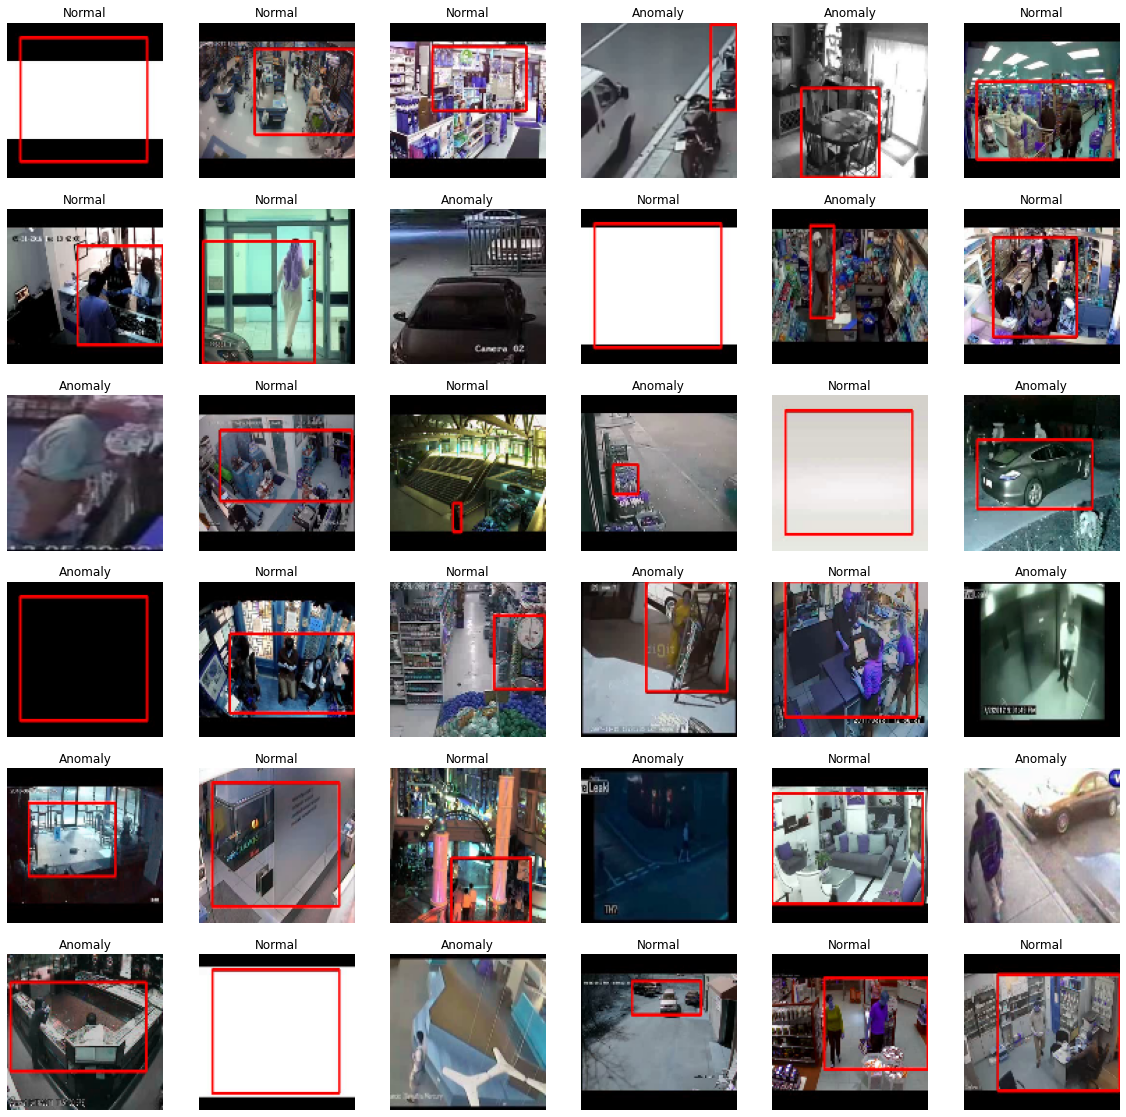

In [54]:
have_a_look(X_train, y_train)

In [55]:
if load_tracker["test_data"] == "n":
    X_test, _ = preprocess(testingData_paths, [])
    save_structure(X_test, "X_test")
else:
    X_test = load_structure("X_test")
    print("Testing data is Loaded")




100%|██████████| 2/2 [00:00<00:00, 238.10it/s]


In [56]:
!mv /content/Models /content/Dataset
!mv /content/Weights /content/Dataset


In [57]:
if load_tracker[model_name] == "n":
    create_model(model_id)
    save_model_plot(model_name)
    print("Model is created!")
else:
    load_model(model_id)
    print("Model is loaded!")

show_summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/Dataset/Models/CNN_3D_Model/assets
Model is created!
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 16, 112, 112, 3)] 0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_____________________________________________________

In [58]:
train(X_train, y_train, val_split=0.2)

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 0.6898 - accuracy: 0.6230 - val_loss: 0.6831 - val_accuracy: 0.7292
Epoch 2/50
4/4 [==============================] - 3s 849ms/step - loss: 0.6799 - accuracy: 0.7277 - val_loss: 0.6725 - val_accuracy: 0.7292
Epoch 3/50
4/4 [==============================] - 3s 850ms/step - loss: 0.6694 - accuracy: 0.7592 - val_loss: 0.6598 - val_accuracy: 0.7292
Epoch 4/50
4/4 [==============================] - 3s 855ms/step - loss: 0.6602 - accuracy: 0.7801 - val_loss: 0.6473 - val_accuracy: 0.7917
Epoch 5/50
4/4 [==============================] - 3s 862ms/step - loss: 0.6473 - accuracy: 0.8220 - val_loss: 0.6388 - val_accuracy: 0.8750
Epoch 6/50
4/4 [==============================] - 3s 866ms/step - loss: 0.6391 - accuracy: 0.8586 - val_loss: 0.6383 - val_accuracy: 0.8333
Epoch 7/50
4/4 [==============================] - 3s 870ms/step - loss: 0.6328 - accuracy: 0.8691 - val_loss: 0.6278 - val_accuracy: 0.8750
Epoch 8/50
4/4 [=======

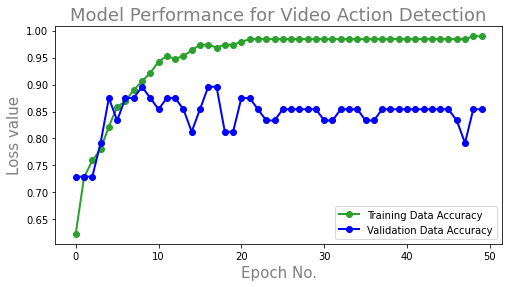

In [59]:
show_model_performance()

In [60]:
train(X_train, y_train, val_split=0)


Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.5837 - accuracy: 0.9665
Epoch 2/50
5/5 [==============================] - 4s 778ms/step - loss: 0.5833 - accuracy: 0.9623
Epoch 3/50
5/5 [==============================] - 4s 779ms/step - loss: 0.5812 - accuracy: 0.9665
Epoch 4/50
5/5 [==============================] - 4s 782ms/step - loss: 0.5794 - accuracy: 0.9749
Epoch 5/50
5/5 [==============================] - 4s 785ms/step - loss: 0.5788 - accuracy: 0.9749
Epoch 6/50
5/5 [==============================] - 4s 785ms/step - loss: 0.5771 - accuracy: 0.9791
Epoch 7/50
5/5 [==============================] - 4s 784ms/step - loss: 0.5774 - accuracy: 0.9749
Epoch 8/50
5/5 [==============================] - 4s 784ms/step - loss: 0.5756 - accuracy: 0.9791
Epoch 9/50
5/5 [==============================] - 4s 781ms/step - loss: 0.5763 - accuracy: 0.9749
Epoch 10/50
5/5 [==============================] - 4s 778ms/step - loss: 0.5749 - accuracy: 0.9791
Epoch 11/50
5/5 [=====

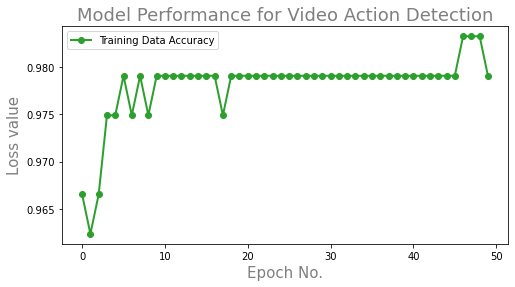

In [61]:
show_model_performance()

In [80]:
y_predict = predict(X_test)


In [79]:
X_test

array([[[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         ...,

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
         

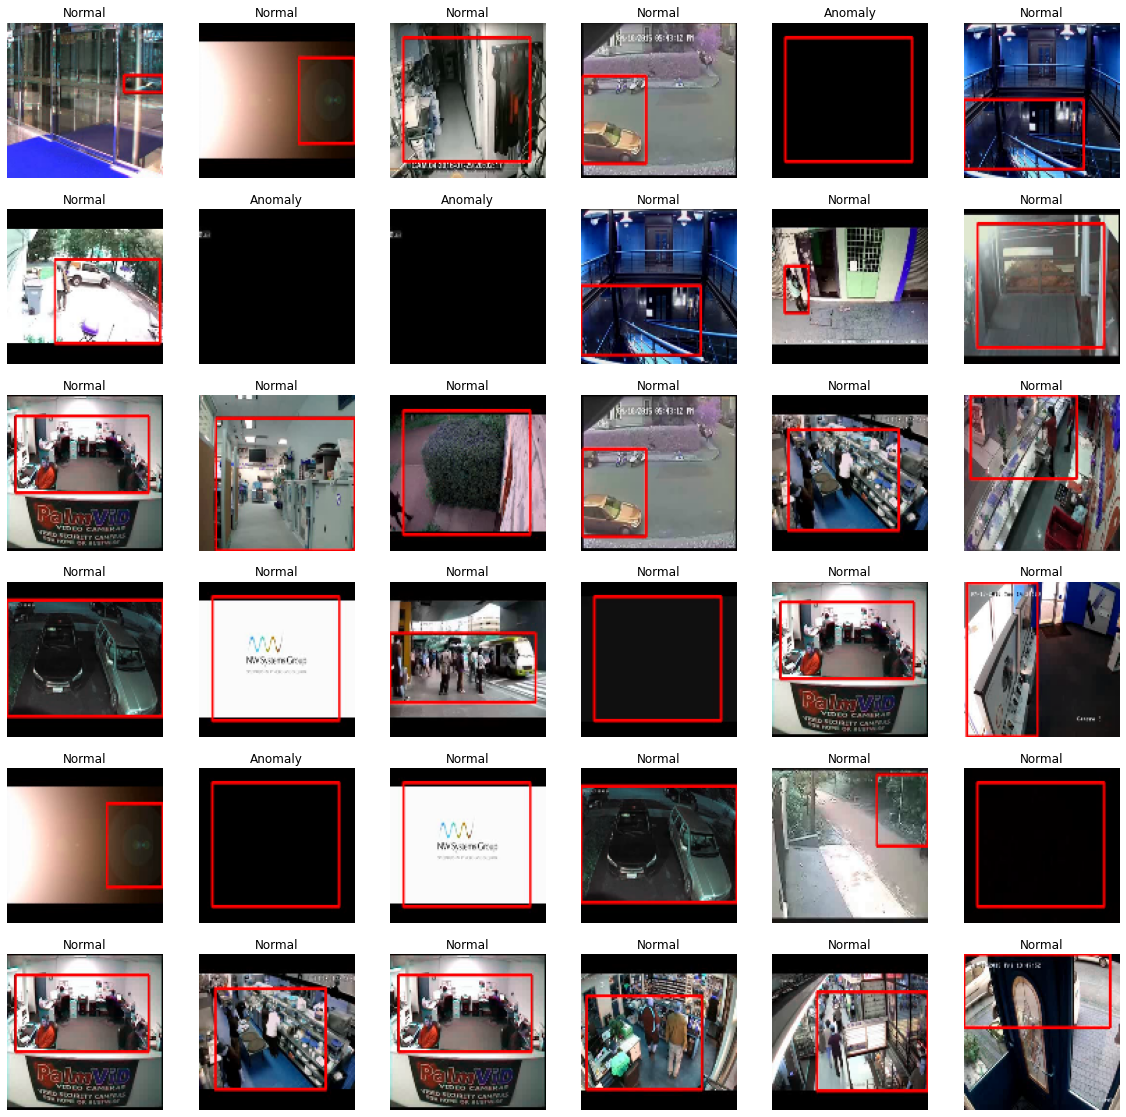

In [81]:
have_a_look(X_test, y_predict)


In [83]:
y_predict

array([[0.54793036, 0.45206964],
       [0.40559423, 0.5944058 ],
       [0.40785202, 0.59214795],
       [0.5479322 , 0.45206773],
       [0.4050585 , 0.59494144],
       [0.5475993 , 0.45240074],
       [0.405464  , 0.594536  ],
       [0.42485705, 0.5751429 ],
       [0.4050601 , 0.5949399 ],
       [0.5369182 , 0.4630818 ],
       [0.40541297, 0.5945871 ],
       [0.54793245, 0.45206758],
       [0.40505916, 0.59494084],
       [0.40508443, 0.59491557],
       [0.54793185, 0.4520681 ],
       [0.4185653 , 0.5814347 ],
       [0.45802096, 0.5419791 ],
       [0.44347918, 0.55652076],
       [0.4050656 , 0.5949344 ],
       [0.40506938, 0.59493065],
       [0.4050585 , 0.59494144],
       [0.43739015, 0.56260985],
       [0.40505853, 0.59494144],
       [0.40505943, 0.59494054],
       [0.4050585 , 0.59494144],
       [0.4050586 , 0.59494144],
       [0.40506956, 0.59493047],
       [0.40657824, 0.59342176],
       [0.4050585 , 0.59494144],
       [0.40516692, 0.5948331 ],
       [0.

In [96]:
create_predictions_csv_file(model_name, y_predict)




100%|██████████| 62/62 [00:00<00:00, 497221.51it/s]


In [97]:
pwd

'/content/Dataset'

In [ ]:

def create_predictions_csv_file(model_name, predictions):
    pred = []

    data_names = get_test_data_names()
    for i in range(len(predictions)):
        pred.append([data_names[i], get_value(predictions[i])])

    np_predictions = np.array(pred)
    np.savetxt(fname=model_name + "_predictions.csv", X=np_predictions, delimiter=",", fmt='%s')

In [86]:
get_test_data_names()




100%|██████████| 2/2 [00:00<00:00, 22250.95it/s]


['Anomaly', 'Normal']

In [66]:
def know_about_test_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))
    
    print("\nWe have", len(vids_shape), " videos.")
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))

In [72]:
def read_test_data_paths():
    data_paths = []

    # for file in tqdm(os.listdir(test_path)):
    #     vid_path = os.path.join(test_path, file)
    #     data_paths.append(vid_path)
    for class_name in classes:
      for file in tqdm(os.listdir(test_path + "/" + class_name)):
          vid_path = os.path.join(test_path + "/" + class_name, file)
          data_paths.append(vid_path)

    return data_paths



def get_test_data_names():
    data_names = []
    for file in tqdm(os.listdir(test_path)):
        data_names.append(file)
    
    return data_names



# def read_train_data_paths():
#     data_paths = []
#     truth = []

#     for class_name in classes:
#         for file in tqdm(os.listdir(train_path + "/" + class_name)):
#             vid_path = os.path.join(train_path + "/" + class_name, file)
#             data_paths.append(vid_path)
#             truth.append(classes[class_name])
    
#     return data_paths, truth

In [73]:
if load_tracker["test_data"] == "n":
    print("Reading Testing Data..")
    testingData_paths = read_test_data_paths()



100%|██████████| 20/20 [00:00<00:00, 47366.50it/s]


100%|██████████| 40/40 [00:00<00:00, 224895.66it/s]

Reading Testing Data..


In [71]:
trainingData_paths

array(['/content/Dataset/Training_set/Anomaly/Vandalism019_x264.mp4',
       '/content/Dataset/Training_set/Anomaly/Stealing030_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos127_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos045_x264.mp4',
       '/content/Dataset/Training_set/Anomaly/Burglary043_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos173_x264.mp4',
       '/content/Dataset/Training_set/Anomaly/Robbery072_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos009_x264.mp4',
       '/content/Dataset/Training_set/Anomaly/Stealing073_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos290_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos154_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos328_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos112_x264.mp4',
       '/content/Dataset/Training_set/Normal/Normal_Videos368_x264.mp4'

In [74]:
testingData_paths

['/content/Dataset/Testing_set/Anomaly/Arrest028_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Robbery031_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Vandalism003_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Assault032_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Robbery012_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Stealing047_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Robbery070_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Stealing097_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Burglary097_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Vandalism009_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Burglary068_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Assault015_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Robbery003_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Burglary059_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Assault046_x264.mp4',
 '/content/Dataset/Testing_set/Anomaly/Vandalism034_x264.mp4',
 '/content/Dat

In [75]:

if load_tracker["test_data"] == "n":
    know_about_test_data(testingData_paths)



100%|██████████| 60/60 [00:00<00:00, 1275.89it/s]


We have 60  videos.
Videos Shapes are:
(320.0, 240.0, 45.0)     2
(320.0, 240.0, 91.0)     2
(320.0, 240.0, 114.0)    2
(320.0, 240.0, 99.0)     2
(320.0, 240.0, 133.0)    2
(320.0, 240.0, 118.0)    2
(320.0, 240.0, 121.0)    2
(320.0, 240.0, 164.0)    1
(320.0, 240.0, 38.0)     1
(320.0, 240.0, 64.0)     1
(67.0, 80.0, 96.0)       1
(320.0, 240.0, 83.0)     1
(320.0, 240.0, 136.0)    1
(320.0, 240.0, 166.0)    1
(320.0, 240.0, 180.0)    1
(320.0, 240.0, 66.0)     1
(320.0, 240.0, 115.0)    1
(320.0, 240.0, 137.0)    1
(320.0, 240.0, 124.0)    1
(320.0, 240.0, 39.0)     1
(320.0, 240.0, 110.0)    1
(320.0, 240.0, 67.0)     1
(320.0, 240.0, 138.0)    1
(320.0, 240.0, 111.0)    1
(320.0, 240.0, 29.0)     1
(205.0, 191.0, 149.0)    1
(320.0, 240.0, 87.0)     1
(320.0, 240.0, 30.0)     1
(320.0, 240.0, 173.0)    1
(161.0, 88.0, 58.0)      1
(320.0, 240.0, 53.0)     1
(320.0, 240.0, 63.0)     1
(320.0, 240.0, 59.0)     1
(320.0, 240.0, 144.0)    1
(320.0, 240.0, 60.0)     1
(320.0, 240.0, 

In [78]:

if load_tracker["test_data"] == "n":
    X_test, _ = preprocess(testingData_paths, [])
    save_structure(X_test, "X_test")
else:
    X_test = load_structure("X_test")
    print("Testing data is Loaded")



  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:00<00:07,  7.93it/s]

  5%|▌         | 3/60 [00:00<00:06,  9.20it/s]

 10%|█         | 6/60 [00:00<00:04, 11.27it/s]

 15%|█▌        | 9/60 [00:00<00:03, 13.73it/s]

 18%|█▊        | 11/60 [00:00<00:03, 14.90it/s]

 22%|██▏       | 13/60 [00:00<00:03, 13.94it/s]

 27%|██▋       | 16/60 [00:00<00:02, 15.82it/s]

 30%|███       | 18/60 [00:01<00:02, 15.53it/s]

 33%|███▎      | 20/60 [00:01<00:02, 14.93it/s]

 37%|███▋      | 22/60 [00:01<00:02, 15.80it/s]

 40%|████      | 24/60 [00:01<00:02, 15.86it/s]

 43%|████▎     | 26/60 [00:01<00:02, 16.81it/s]

 48%|████▊     | 29/60 [00:01<00:01, 19.01it/s]

 53%|█████▎    | 32/60 [00:01<00:01, 19.42it/s]

 58%|█████▊    | 35/60 [00:01<00:01, 17.68it/s]

 62%|██████▏   | 37/60 [00:02<00:01, 18.03it/s]

 65%|██████▌   | 39/60 [00:02<00:01, 18.46it/s]

 70%|███████   | 42/60 [00:02<00:00, 20.11it/s]

 75%|███████▌  | 45/60 [00:02<00:00, 18.33it/s]

 78%|███████▊  | 47/60 [00:02<0

In [89]:
!cp -a /content/Dataset/Testing_set/Anomaly /content/Structures
!cp -a /content/Dataset/Testing_set/Normal /content/Structures

In [91]:
!cp -a  /content/Structures/Anomaly/. /content/Structures
!cp -a /content/Structures/Normal/. /content/Structures

In [92]:
!rm -rf /content/Dataset/Testing_set/Anomaly 
!rm -rf /content/Dataset/Testing_set/Normal 

In [93]:
test_path  = "/content/Structures"

In [94]:
def get_test_data_names():
    data_names = []
    for file in tqdm(os.listdir(test_path)):
        data_names.append(file)
    
    return data_names


In [95]:
get_test_data_names()



100%|██████████| 62/62 [00:00<00:00, 424913.15it/s]


['Normal_Videos753_x264.mp4',
 'Arrest028_x264.mp4',
 'Normal_Videos218_x264.mp4',
 'Normal_Videos734_x264.mp4',
 'Normal_Videos265_x264.mp4',
 'Normal_Videos706_x264.mp4',
 'Normal_Videos735_x264.mp4',
 'Normal_Videos433_x264.mp4',
 'Normal_Videos509_x264.mp4',
 'Normal_Videos818_x264.mp4',
 'Normal_Videos356_x264.mp4',
 'Robbery031_x264.mp4',
 'Vandalism003_x264.mp4',
 'Normal_Videos663_x264.mp4',
 'Assault032_x264.mp4',
 'Normal_Videos611_x264.mp4',
 'Normal_Videos065_x264.mp4',
 'Robbery012_x264.mp4',
 'Normal_Videos354_x264.mp4',
 'Stealing047_x264.mp4',
 'Normal_Videos326_x264.mp4',
 'Robbery070_x264.mp4',
 'Normal_Videos117_x264.mp4',
 'Anomaly',
 'Stealing097_x264.mp4',
 'Normal_Videos414_x264.mp4',
 'Normal_Videos737_x264.mp4',
 'Burglary097_x264.mp4',
 'Vandalism009_x264.mp4',
 'Normal_Videos007_x264.mp4',
 'Burglary068_x264.mp4',
 'Assault015_x264.mp4',
 'Normal_Videos756_x264.mp4',
 'Normal_Videos374_x264.mp4',
 'Normal_Videos823_x264.mp4',
 'Normal',
 'Robbery003_x264.mp4'